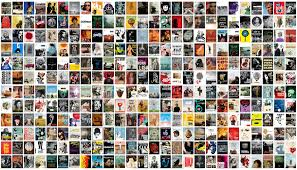

# IMDb Top 250 Movies Web Scraper

This notebook is designed to scrape movie data from IMDb, focusing on the Top 250 movies. Our goal is to efficiently collect key details for each film by first extracting the main list and then gathering additional information from individual movie pages.

For each movie, we’ll capture:

- Title
- Release Year
- Content Rating
- Duration
- IMDb Rating
- Popularity Metric
- Up to Three Genre Tags
- Top Three Star Actors
- Number of Oscar Nominations
- Number of Oscar Wins


How It Works: 
- **Scraping the Top 250 List** – Using Selenium and BeautifulSoup, we’ll extract the core movie data from IMDb’s Top 250 page.
- **Fetching Additional Movie Details** – With this initial dataset, we’ll visit each movie’s individual page to collect more detailed information using BeautifulSoup.
- **Data Output** – The final dataset will be stored in a pandas DataFrame and exported as a CSV file for further analysis.


By automating this process, we create a structured dataset that can be used for deeper insights into IMDb’s top-rated films. 🚀

# Install Dependencies for Selenium and WebDriver Manager

In [ ]:
!pip install selenium webdriver-manager

# Imports

In [ ]:
import subprocess

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait

import time
import random

from concurrent.futures import ThreadPoolExecutor, as_completed

from bs4 import BeautifulSoup
import json
import requests

import pandas as pd
import numpy as np
import re

from IPython.display import FileLink

# Configuring and Initializing a Headless Chrome WebDriver

This function, `chrome_driver_options()`, sets up and returns a Selenium WebDriver instance with optimized Chrome options for web scraping. The configuration includes:

- A custom user-agent to simulate a real browser session.
- Headless mode for running Chrome without a GUI.
- Performance optimizations like --no-sandbox, --disable-gpu, and --disable-dev-shm-usage to enhance stability, especially in cloud environments like Colab.
- Remote debugging support to avoid DevTools errors.
- Timeout settings to ensure long-running scripts don’t hang indefinitely.

In [ ]:
def start_browser():
    chrome_options = Options()

    chrome_options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.6834.160 Safari/537.36")
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--disable-dev-shm-usage')  # Important for Colab
    chrome_options.add_argument('--remote-debugging-port=9222')  # To fix DevToolsActivePort issue
    
    service = Service(ChromeDriverManager().install()) 
    driver = webdriver.Chrome(service=service, options=chrome_options)  # Return WebDriver instance
    driver.set_page_load_timeout(60)  # Increase timeout to 60 seconds
    driver.set_script_timeout(120)  # Increase script timeout as well

    return driver

In [ ]:
# Test that Chrome is working
driver = start_browser()
driver.get("https://www.google.com")
print(driver.title)  
driver.quit()

# Scrape IMDb for the Top 250 Movie Data

Time to grab some popcorn 🍿! This function does the heavy lifting, navigating to IMDb, grabbing movie details, and making sure we get all much of the movie info like rank, title, year, duration, genre, and ratings.

Here’s the game plan:
- Visit IMDb’s Top 250 page using Selenium.
- Extract movie details from IMDb’s embedded JSON data.
-  Pick up extra info (year & duration) that’s missing from the JSON.
- Package it all up in a clean format for analysis.

By the end, we’ll have a solid dataframe of top-rated movies. 

In [ ]:
# Links for scraping the IMDb
imdb_url = "https://www.imdb.com"
top_250_url = 'https://www.imdb.com/chart/top/'


In [ ]:
def get_top_movies(browser):
    """Scrape IMDb's Top 250 movies and return a structured dataset."""
    try:
        # Step 1: Fetch page source
        print("Fetching IMDb Top 250 page...")
        browser.get(top_250_url)
        
        time.sleep(10)  # Allow JavaScript to load
        
        page_source = browser.page_source
        soup = BeautifulSoup(page_source, 'html.parser')

        # Step 2: Extract JSON data for the Top 250 Movies page
        script_tag = soup.find('script', {'type': "application/ld+json"})
        if not script_tag:
            print("No JSON data found.")
            return None
        json_data = json.loads(script_tag.text).get('itemListElement', [])

        # Step 3: Extract metadata (year, duration) because it's not in the JSON
        metadata_divs = soup.find_all('div', class_='sc-d5ea4b9d-6 hBxwRe cli-title-metadata')

        movie_data = []
        for index, movie in enumerate(json_data):
            movie_info = movie['item']
            title = movie_info['name']
            rank = index + 1
            genre = movie_info.get("genre", None)
            content_rating = movie_info.get("contentRating", None)
            imdb_rating = movie_info.get("aggregateRating", {}).get("ratingValue", np.nan)
            url = movie_info["url"]

            # Extract metadata (year, duration)
            if index < len(metadata_divs):
                spans = metadata_divs[index].find_all('span')
                year = spans[0].text if len(spans) > 0 else 'N/A'
                duration = spans[1].text if len(spans) > 1 else 'N/A'
            else:
                year, duration = np.nan, np.nan

            # Store the extracted data
            movie_data.append({
                'rank': rank,
                'title': title,
                'year': year,
                'rating': content_rating,
                'duration': duration,
                'imdb_rating': imdb_rating,
                'genre': genre,
                'movie_url': url
            })
        
        return movie_data

    except Exception as e:
        print("Error scraping IMDb Top 250:", e)
        return None

In [ ]:
# Kick-off the scraping
print("Starting browser...")
browser = start_browser()

print("Scraping IMDb Top 250 movies...")
movies_list = get_top_movies(browser)

if movies_list:
    top_movies_df = pd.DataFrame(movies_list)
    print("Top movies dataframe created:")
    print(top_movies_df.head())

browser.quit()

## Results from Scraping the Top 250 Movies

Let's take a closer look at what was returned in the `top_movies_df` dataframe. 

In [ ]:
# Did we get 250 movies? 
len(top_movies_df)

In [ ]:
# Reviewing the data collected
top_movies_df.info()

In [ ]:
# Checking for NaN values (an issue of earlier iterations)
top_movies_df.isna().sum()

In [ ]:
# Examining the NaN values
rows_with_nans = top_movies_df[top_movies_df.isna().any(axis=1)]
rows_with_nans

In [ ]:
# Checking for duplicates
top_movies_df.duplicated().sum()

In [ ]:
# Taking a closer look at our work
top_movies_df.head(20)

### Conclusions From Scraping the Top 250 Movies

We have data! It looks like some films weren't rated. 

When this code was originally created, we quickly learned that this page had dynamic content and using Selenium would help us out here. Discovering that we could also use JSON to examine the content of the page also improved our function for scraping the page data. 

**What's missing:**
- popularity score,
- information about the stars of each film (actor names),
- Oscar wins and nominations

We'll now collect the missing movie details. 

# Scrape IMDb Movie Pages for Additional Movie Details

Now that we have our Top 250 movies, it's time for a deep dive. We’ll visit each movie’s individual IMDb page to grab some extra details that aren’t included in the main list. This means more insights and a more complete dataset!

Here’s what we’re after:
- **Popularity Score** – How trending is this movie?
- **Top 3 Stars** – The biggest names from the cast, plus the actor links for future scraping.
- **The number of Oscar Wins & Nominations** – An interesting statistic for us to think on later.

To do this, we’ll:
1. Visit each movie’s IMDb page (using links from our Top 250 list).
2. Parse the page with BeautifulSoup to extract the extra details.
3. Save this to a dataframe

By the end, we’ll be able to merge the dataframes and have a richer dataset, perfect for analysis.


## Fetching the Additional Movie Detail Metrics

How this is organized:

1. Functions for gathering metrics: Each metric we’re collecting has its own function, allowing us to test and debug them separately. 

- `fetch_page_soup(movie_url)` - Gets each movie url and parses it with BeautifulSoup.
- `find_popularity_score(soup)`– Retrieves the popularity score from the movie page.
- `find_star_data(soup)` - Extract the first 3 actors' names and links.
- `find_awards(soup)` - Retrieve Oscar wins and nominations from the awards section of the movie page.

You'll see a test block below each function, in case you need to debug before moving onto the whole scraping process.

Managing the scraping process: 

Once the individual functions are in place, we use `scrape_movie_details(movie_row)` to task manage the scraping workflow.

- This function calls all of the functions for the movie metrics.
- It compiles the collected data into a dictionary.
- There is a test code block with a small sample from our `top_movies_df` dataframe that we created earlier. 

By structuring the notebook this way, we ensure each part of the process can be tested independently before combining everything into a full dataset.

**Functions for gathering the movie details we need:**

In [ ]:
# Define headers to mimic a real browser
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.6834.160 Safari/537.36"
}

In [ ]:
def fetch_page_soup(movie_url):
    """Get the page and parse the html using BeautifulSoup """
    try:
        # Fetch the page, pretending we're a web browser
        response = requests.get(movie_url, headers=HEADERS)
        
        # Check the response code (200 = success!)
        if response.status_code != 200:
            print("Failed to retrieve page", movie_url, "status code:", response.status_code)
            return None
        
        # Parse the page with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')
        
        return soup
    
    except Exception as e:
        print("Error fetching page", movie_url, e)
        return None


In [ ]:
# # Test fetching pages
# test_link = "https://www.imdb.com/title/tt0111161/"
# test_url =  fetch_page_soup(test_link)
# if test_url: 
#     print(test_url.prettify()[:500])

In [ ]:
def find_popularity_score(soup):
    """Extract the popularity score from the movie page."""
    
    # Find the popularity score
    pop_score_element = soup.find('div', {'data-testid': 'hero-rating-bar__popularity__score'})
    
    if pop_score_element:
        try:
            return int(pop_score_element.get_text(strip=True).replace(',', ''))
        except ValueError:
            return None  # Handle cases where conversion fails
    return None

In [ ]:
# # Test the pop score
# soup = fetch_page_soup("https://www.imdb.com/title/tt0111161/") # Expecting 54
# pop_score = find_popularity_score(soup)
# print(f"Popularity Score: {pop_score}")

If there are only 2 stars per movie, the dictionary will only contain 2 star. This went through a couple of iterations to land here. 

In [ ]:
def find_star_data(soup):
    """Extract the first 3 actors' names and links."""
    star_data = {}
    
    # Find the stars
    # Results from soup: <a data-testid="title-cast-item__actor" href="/name/nm0000158/">Leonardo DiCaprio</a>
    actor_tags = soup.select('a[data-testid="title-cast-item__actor"]')[:3]  # Limit to top 3 actors
    
    # idx keeps track of each actors position 1, 2, 3
    for idx, actor_tag in enumerate(actor_tags):
        actor_name = actor_tag.text.strip()
        actor_url = "https://www.imdb.com" + actor_tag["href"]
        
        # Generate the key
        star_data[f"star_{idx + 1}"] = actor_name
        star_data[f"star_{idx + 1}_link"] = actor_url

    return star_data

In [ ]:
# # Test the star data
# soup = fetch_page_soup("https://www.imdb.com/title/tt1375666/")
# star_data = find_star_data(soup)
# print(star_data)

In [ ]:
def find_awards(soup):
    """Extract Oscar wins and nominations from the awards section."""
    
    # Find the awards section
    awards_section = soup.find('div', {'data-testid': 'awards'})
    oscar_wins = oscar_nominations = 0

    if awards_section:
        awards_text = awards_section.get_text(strip=True)
        win_match = re.search(r'Won (\d+)', awards_text)
        nom_match = re.search(r'Nominated for (\d+)', awards_text)

        oscar_wins = int(win_match.group(1)) if win_match else 0
        oscar_nominations = int(nom_match.group(1)) if nom_match else 0

    return oscar_wins, oscar_nominations


In [ ]:
# # Test the awards data
# soup = fetch_page_soup("https://www.imdb.com/title/tt0167260/")
# oscar_wins, oscar_nominations = find_awards(soup)
# print("Oscar Wins:", oscar_wins, "Oscar Nominations:", oscar_nominations)

Now that we can gather the extra movie data for individual movie links, we'll put everything together in a function. This function puts all of the extra details together in and returns a dictionary.

In [ ]:
def scrape_movie_details(movie_row):
    """Scrape IMDb details for a single movie"""
    try:
        movie_title = movie_row['title']
        movie_url = movie_row['movie_url']

        print(f"Scraping: {movie_title}")
        
        # Get the individual movie page
        soup = fetch_page_soup(movie_url)
        if not soup:
            return None  # Skip if the page request fails

        # Get the movie details we need
        pop_score = find_popularity_score(soup)
        star_data = find_star_data(soup)
        oscar_wins, oscar_nominations = find_awards(soup)
        
        # Put the dictionary together for each movie
        movie_details = {
            'title': movie_title,
            'popularity_score': pop_score,
            'oscar_wins': oscar_wins,
            'oscar_nominations': oscar_nominations
        }

        movie_details.update(star_data) # Add the star data to the dictionary

        # Small randomized delay to avoid getting blocked
        time.sleep(random.uniform(1, 3))

        return movie_details 
    except Exception as e:
        print("Error scraping", movie_title, e)
        return None


## Scaling the Web Scraping

Scraping hundreds of movie pages one by one would take forever, so we speed things up using parallel processing and batching. 

How we do it: 

1. `scrape_all_movies(movies_df)` – Fast, Multi-Threaded Scraping.
- Uses ThreadPoolExecutor to scrape multiple movies at the same time (up to 10 at once).
- Submits each movie to be processed in parallel and collects results as they finish.
- Handles errors gracefully, so one failed request doesn’t stop everything.

2. scrape_movies_in_batches(movies_df) – Avoiding IMDb Blocks
- We learned that IMDb doesn’t like too many requests at once, so we scrape in batches of 50 movies.
- After each batch, the script pauses for 5 seconds to stay under the radar.
- When all batches are done, we merge everything into a single DataFrame.

3. Output – A Clean, Scraped Movie Dataset
At the end, we get a dataframe with the additional IMDb movie details for every movie, ready to combine and create our working movie dataframe and csv file for analysis. 

In [ ]:
def scrape_all_movies(movies_df, max_workers=10):
    """Scrape IMDb data for multiple movies concurrently and return a DataFrame."""
    # Create a list to store results
    results = []
    
    # Create a pool of workers that independently scrape each row in the dataframe
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(scrape_movie_details, row): row['title'] for _, row in movies_df.iterrows()}
        
        # Process results as they complete, but doesn't wait for all to complete to process
        for future in as_completed(futures): 
            try:
                result = future.result() # Retrieve the scraped data from the thread
                if result:  # Avoid appending None values
                    results.append(result)
            except Exception as e:
                print("Error:", e)

    return pd.DataFrame(results)

In [ ]:
def scrape_movies_in_batches(movies_df, batch_size=50, max_workers=10):
    """Scrape movies in batches to prevent hitting IMDb rate limits."""
    
    total_movies = len(movies_df)
    all_results = []

    for i in range(0, total_movies, batch_size):
        batch = movies_df.iloc[i:i + batch_size]
        print(f"Processing batch {i//batch_size + 1} ({len(batch)} movies)...")

        # Run concurrent scraping for this batch
        df_batch = scrape_all_movies(batch, max_workers)

        # Store batch results in memory
        all_results.append(df_batch)

        # Sleep between batches to avoid IMDb’s rate limit
        time.sleep(5)

    # Combine all batches into a final DataFrame
    final_df = pd.concat(all_results, ignore_index=True)
    return final_df

In [ ]:
# # Test the scraper on a small dataset
# # Load top movies dataset
# test_movies_df = top_movies_df[['title', 'movie_url']][:10]  # Testing with 10 movies

# # Run concurrent scraping
# movie_results_df = scrape_movies_in_batches(test_movies_df)

# # Display results of our test
# movie_results_df.head(10)

In [ ]:
# Check the length of dataframe
len(top_movies_df)

## Start the Movie Details Scraping

This process can take a few minutes. Not long enough for a coffee, but maybe.

In [ ]:
# Scrape for movie details 
print("Ready to scrape for movie details!")

# Search using the top 250 movies
movies_to_scrape_df = top_movies_df[['title', 'movie_url']]

# Run concurrent scraping
movie_results_df = scrape_movies_in_batches(movies_to_scrape_df)

# Display the results
print(movie_results_df.head())

## Checking the Results of the Movie Details Scraping

The scraped movie details are in the dataframe `movie_results_df`. The full process took a couple of minutes. A vast improvement over running the scrape for each page individually.


In [ ]:
# Check the length
len(movie_results_df)

In [ ]:
# Print the first few rows of results
movie_results_df.head(50)

In [ ]:
# Check for NaNs
movie_results_df.isna().sum()

In [ ]:
# Check for duplicates
movie_results_df.duplicated().sum()

In [ ]:
# Examining the NaN values
rows_with_nans = movie_results_df[movie_results_df.isna().any(axis=1)]
rows_with_nans

### Conclusions for the Movie Details Scraping

- **Popularity score:** Some movies don't have a popularity score.
- The film: "Kimetsu no Yaiba: Tsuzumi Yashiki-hen" seems to have an error which might be due to its title. There are also multiple versions of this movie listed in IMDb. 



# Combining the Datasets

Finally, we'll combine the scraped movie details with our original dataset using a left merge on the title. 

This ensures each movie keeps its original info while adding the new IMDb data. We'll check the results and preview the first 30 rows to confirm everything looks good!

In [ ]:
# Merge the dataframes 
combined_movie_details = pd.merge(top_movies_df, movie_results_df, on='title', how='left')

In [ ]:
# Check our work
combined_movie_details.info()

In [ ]:
combined_movie_details.head(30)

# Finalizing the Movie Dataset

We'll now save our merged datasets into a file for future data analysis. 

In [ ]:
# Save the movies dataframe as a .csv (this will save to your datasets folder)
combined_movie_details.to_csv('datasets/movie_details_9FEB.csv', index=False)

# Then create a download link for that file
display(FileLink('movie_details_9FEB.csv'))

# Next Steps

The improved web scraping results look great! While not perfect, they provide enough data for the next phase of the project.

The `movie_details` CSV we just built will now serve as the input for our Actors Web Scraping work. Check out that project notebook for the next steps!
